In [ ]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ninadaithal/imagesoasis

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
imagesoasis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip imagesoasis.zip

Archive:  imagesoasis.zip
replace Data/Mild Dementia/OAS1_0028_MR1_mpr-1_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/Mild Dementia/OAS1_0028_MR1_mpr-1_101.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

In [ ]:
import os
import shutil
import random

# Define paths
original_dataset_dir = "/content/Data"
new_dataset_dir = "/content/New_Data"

# Ensure new dataset directory exists
os.makedirs(new_dataset_dir, exist_ok=True)

# Define number of samples per class (35k total, distributed across classes)
target_samples = 35000
num_classes = 4  # Update if needed
samples_per_class = target_samples // num_classes

# Sample files from each class
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    new_class_path = os.path.join(new_dataset_dir, class_name)

    if os.path.isdir(class_path):
        os.makedirs(new_class_path, exist_ok=True)

        # Get all images in the class
        all_images = os.listdir(class_path)
        selected_images = random.sample(all_images, min(samples_per_class, len(all_images)))

        # Copy selected images
        for img in selected_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(new_class_path, img))

print("Subset dataset created with 35k images.")

Subset dataset created with 35k images.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
# Set paths to the dataset directories
data_dir = "/content/New_Data"  # Path to the main data directory

# Parameters
image_size = (224, 224)  # MobileNetV2 input size
batch_size = 32
initial_epochs = 10
additional_epochs = 5

In [10]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80-20 split
)

# Load training and validation sets from directory
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 27020 images belonging to 4 classes.
Found 6752 images belonging to 4 classes.


In [11]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Load MobileNetV2 (pre-trained)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
output_layer = Dense(len(class_labels), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ cast_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [12]:
# Train for first 10 epochs
history_10 = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 94s 98ms/step - accuracy: 0.6016 - loss: 0.9224 - val_accuracy: 0.5878 - val_loss: 0.9056
Epoch 2/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - accuracy: 0.7575 - loss: 0.5855 - val_accuracy: 0.6158 - val_loss: 0.8753
Epoch 3/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 83s 70ms/step - accuracy: 0.7966 - loss: 0.5125 - val_accuracy: 0.5973 - val_loss: 0.9348
Epoch 4/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.8209 - loss: 0.4600 - val_accuracy: 0.6195 - val_loss: 0.9104
Epoch 5/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 69s 82ms/step - accuracy: 0.8353 - loss: 0.4327 - val_accuracy: 0.6097 - val_loss: 0.9735
Epoch 6/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - accuracy: 0.8348 - loss: 0.4164 - val_accuracy: 0.6049 - val_loss: 0.9574
Epoch 7/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 57s 68ms/step - accuracy: 0.8460 - loss: 0.3956 - val_accuracy: 0.6092 - val_loss: 0.9691
Epoch 8/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 59s 69ms/step - accuracy: 0.8560 - loss: 0.3778 - 

In [13]:
# Save model
model.save("mobilenet_oasis_10_epochs.keras")

In [14]:
# Evaluate after 10 epochs
y_true = train_generator.classes
y_pred = np.argmax(model.predict(train_generator), axis=1)

accuracy_10 = accuracy_score(y_true, y_pred)
precision_10 = precision_score(y_true, y_pred, average='weighted')
recall_10 = recall_score(y_true, y_pred, average='weighted')

print(f"Epoch 10 - Train Accuracy: {accuracy_10:.4f}, Precision: {precision_10:.4f}, Recall: {recall_10:.4f}")
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

accuracy_10 = accuracy_score(y_true, y_pred)
precision_10 = precision_score(y_true, y_pred, average='weighted')
recall_10 = recall_score(y_true, y_pred, average='weighted')

print(f"Epoch 10 - Test Accuracy: {accuracy_10:.4f}, Precision: {precision_10:.4f}, Recall: {recall_10:.4f}")

845/845 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step
Epoch 10 - Train Accuracy: 0.4026, Precision: 0.3847, Recall: 0.4026
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step
Epoch 10 - Test Accuracy: 0.4297, Precision: 0.3820, Recall: 0.4297


In [15]:
# Continue training for epochs 11-15
history_15 = model.fit(train_generator, epochs=15, validation_data=val_generator, initial_epoch=10)

Epoch 11/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - accuracy: 0.8627 - loss: 0.3493 - val_accuracy: 0.6265 - val_loss: 1.0077
Epoch 12/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 61s 73ms/step - accuracy: 0.8628 - loss: 0.3515 - val_accuracy: 0.5752 - val_loss: 1.2118
Epoch 13/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 56s 67ms/step - accuracy: 0.8664 - loss: 0.3389 - val_accuracy: 0.5955 - val_loss: 1.0799
Epoch 14/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/step - accuracy: 0.8672 - loss: 0.3369 - val_accuracy: 0.6120 - val_loss: 1.0420
Epoch 15/15
845/845 ━━━━━━━━━━━━━━━━━━━━ 59s 70ms/step - accuracy: 0.8733 - loss: 0.3244 - val_accuracy: 0.6160 - val_loss: 1.0893


In [16]:
# Save model
model.save("mobilenet_oasis_15_epochs.keras")

In [18]:
# Evaluate after 15 epochs
y_true = train_generator.classes
y_pred_15 = np.argmax(model.predict(train_generator), axis=1)

accuracy_15 = accuracy_score(y_true, y_pred_15)
precision_15 = precision_score(y_true, y_pred_15, average='weighted')
recall_15 = recall_score(y_true, y_pred_15, average='weighted')

print(f"Epoch 15 - Train Accuracy: {accuracy_15:.4f}, Precision: {precision_15:.4f}, Recall: {recall_15:.4f}")
y_true = val_generator.classes
y_pred_15 = np.argmax(model.predict(val_generator), axis=1)

accuracy_15 = accuracy_score(y_true, y_pred_15)
precision_15 = precision_score(y_true, y_pred_15, average='weighted')
recall_15 = recall_score(y_true, y_pred_15, average='weighted')

print(f"Epoch 15 - Test Accuracy: {accuracy_15:.4f}, Precision: {precision_15:.4f}, Recall: {recall_15:.4f}")

845/845 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step
Epoch 15 - Train Accuracy: 0.3829, Precision: 0.3805, Recall: 0.3829
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step
Epoch 15 - Test Accuracy: 0.4079, Precision: 0.3824, Recall: 0.4079


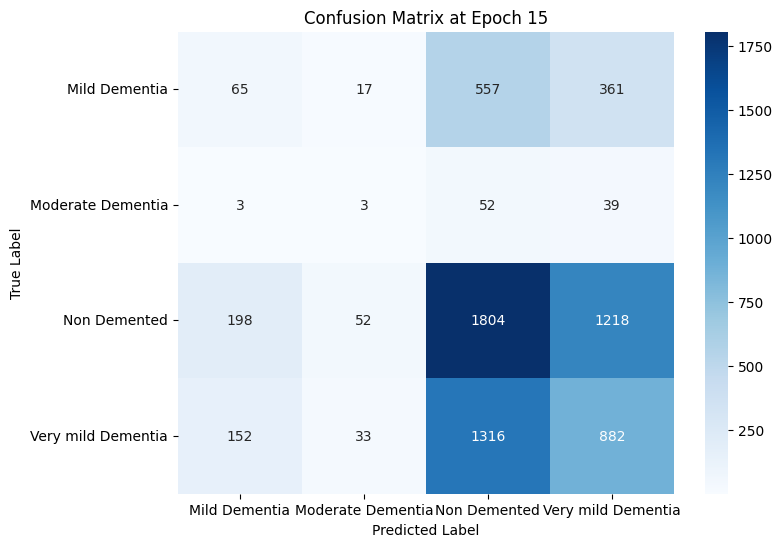

In [19]:
# Plot confusion matrix after 15 epochs
cm_15 = confusion_matrix(y_true, y_pred_15)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_15, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix at Epoch 15')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Clear session to free up memory
tf.keras.backend.clear_session()